# Hospital Length of stay data exploration and feature engineering

This has been adapted from this excellent article:  https://towardsdatascience.com/predicting-hospital-length-of-stay-at-time-of-admission-55dfdfe69598.

The changes are for making this work with Watson Studio and using the data exploration and preparation parts to generate a csv file to be used with:
Watson Machine Learning
SPSS Model Maker

In [17]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import seaborn as sns

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The following csv files were downloaded from the MIMIC-III database [source](https://mimic.physionet.org/).

Highlight the cell below.  Then, using the 1010 button in Watson Studio, click on the ADMISSIONS.csv file and Insert into code drop down.  Insert the ADMISSIONS.csv data.  You will see some code generated to securely connect to the project's cloud object storage area and insert the data into a data frame.
Change the df_data_ value to df

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


Repeat the above step, but for PATIENTS.csv
Change the df_data_ value to df_pat

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


...and again for DIAGNOSES_ICD.csv.
Change the df_data_ value to df_diagcode so that it will work with the rest of the notebook.

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


...and finally for ICUSTAYS.csv
Change the df_data_ value to df_icu

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [ ]:
# Primary Admissions information
df = pd.read_csv('data/ADMISSIONS.csv')

# Patient specific info such as gender
df_pat = pd.read_csv('data/PATIENTS.csv')

# Diagnosis for each admission to hospital
df_diagcode = pd.read_csv('data/DIAGNOSES_ICD.csv')

# Intensive Care Unit (ICU) for each admission to hospital
df_icu = pd.read_csv('data/ICUSTAYS.csv')

<a class="anchor" id="Data-Exploration"></a>
# 2. Data Exploration and Feature Engineering

In this section, I'll examine the various imported MIMIC DataFrames to understand how the data is distributed. Additionaly, I need to figure out a strategy to extract the target Length-of-Stay (LOS) values and understand what features (independent variables) may be useful in predicting LOS. 

**NOTE**: I have to perform a good amount of feature engineering in this section to enable the visualization of certain data categories. Any additional data 'tidyness' problems will be addressed in the 'Data Preprocessing' section including a comprehensive preprocessing function. 

<a class="anchor" id="ADMISSIONS.csv"></a>
## 2.1 ADMISSIONS.csv Exploration 

From [MIMIC](https://mimic.physionet.org/mimictables/admissions/): The ADMISSIONS table gives information regarding a patient’s admission to the hospital. Since each unique hospital visit for a patient is assigned a unique HADM_ID, the ADMISSIONS table can be considered as a definition table for HADM_ID. Information available includes timing information for admission and discharge, demographic information, the source of the admission, and so on.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
ROW_ID                  58976 non-null int64
SUBJECT_ID              58976 non-null int64
HADM_ID                 58976 non-null int64
ADMITTIME               58976 non-null object
DISCHTIME               58976 non-null object
DEATHTIME               5854 non-null object
ADMISSION_TYPE          58976 non-null object
ADMISSION_LOCATION      58976 non-null object
DISCHARGE_LOCATION      58976 non-null object
INSURANCE               58976 non-null object
LANGUAGE                33644 non-null object
RELIGION                58518 non-null object
MARITAL_STATUS          48848 non-null object
ETHNICITY               58976 non-null object
EDREGTIME               30877 non-null object
EDOUTTIME               30877 non-null object
DIAGNOSIS               58951 non-null object
HOSPITAL_EXPIRE_FLAG    58976 non-null int64
HAS_CHARTEVENTS_DATA    58976 non-null int64
dtypes: int64(5), objec

In [7]:
print('Dataset has {} number of unique admission events.'.format(df['HADM_ID'].nunique()))
print('Dataset has {} number of unique patients.'.format(df['SUBJECT_ID'].nunique()))

Dataset has 58976 number of unique admission events.
Dataset has 46520 number of unique patients.


<a class="anchor" id="LOS_FE"></a>
### 2.1.1 Length-of-Stay (Feature Engineering)

The first task is to figure out a way to calculate the LOS. LOS is defined as the time between admission and discharge from the hospital.

In [8]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [9]:
# Convert admission and discharge times to datatime type
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])

# Convert timedelta type into float 'days', 86400 seconds in a day
df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.total_seconds()/86400

In [10]:
# Verify
df[['ADMITTIME', 'DISCHTIME', 'LOS']].head()

,ADMITTIME,DISCHTIME,LOS
0,2196-04-09 12:26:00,2196-04-10 15:54:00,1.144444
1,2153-09-03 07:15:00,2153-09-08 19:10:00,5.496528
2,2157-10-18 19:34:00,2157-10-25 14:00:00,6.768056
3,2139-06-06 16:14:00,2139-06-09 12:48:00,2.856944
4,2160-11-02 02:06:00,2160-11-05 14:55:00,3.534028


In [11]:
df['LOS'].describe()

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

In [12]:
# Look at what is happening with negative LOS values
df[df['LOS'] < 0]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS
425,534,417,102633,2177-03-23 16:17:00,2177-03-23 07:20:00,2177-03-23 07:20:00,URGENT,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,NaN,NaN,ORGAN DONOR ACCOUNT,1,1,-0.372917
456,237,181,102631,2153-10-12 09:49:00,2153-10-12 06:29:00,2153-10-12 06:29:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,NaN,PROTESTANT QUAKER,MARRIED,WHITE,2153-10-12 06:23:00,2153-10-12 07:45:00,DISSECTING ANEURYSIM,1,1,-0.138889
692,644,516,187482,2197-07-31 20:18:00,2197-07-31 01:10:00,2197-07-31 01:10:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,JEWISH,WIDOWED,UNKNOWN/NOT SPECIFIED,2197-07-31 11:31:00,2197-07-31 14:35:00,RESPIRATORY DISTRESS,1,0,-0.797222
1911,1640,1334,138015,2137-09-02 14:43:00,2137-09-02 12:00:00,2137-09-02 12:00:00,NEWBORN,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,NaN,PROTESTANT QUAKER,NaN,WHITE,NaN,NaN,NEWBORN,1,1,-0.113194
1970,1699,1381,181430,2189-01-02 14:25:00,2189-01-02 12:00:00,2189-01-02 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,UNOBTAINABLE,MARRIED,WHITE,2189-01-02 10:31:00,2189-01-02 15:56:00,STROKE;TELEMETRY,1,1,-0.100694
2784,2935,2420,135098,2184-12-01 19:28:00,2184-12-01 16:50:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,ENGL,CATHOLIC,SINGLE,WHITE,2184-11-30 11:14:00,2184-12-01 03:00:00,ALTERED MENTAL STATUS,0,1,-0.109722
3342,3244,2677,108011,2128-04-16 12:28:00,2128-04-16 12:00:00,2128-04-16 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,NOT SPECIFIED,WIDOWED,WHITE,2128-04-16 03:23:00,2128-04-16 14:35:00,PANCREATITIS,1,1,-0.019444
3622,3447,2858,190088,2108-09-25 15:29:00,2108-09-25 12:00:00,2108-09-25 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,WIDOWED,WHITE,NaN,NaN,MYOCARDIAL INFARCTION\CATH,1,1,-0.145139
3996,3894,3229,161198,2134-11-30 18:19:00,2134-11-30 12:00:00,2134-11-30 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,UNOBTAINABLE,NaN,WHITE,2134-11-30 16:40:00,2134-11-30 19:07:00,HEAD BLEED,1,1,-0.263194
4445,4879,4023,170307,2153-05-27 11:14:00,2153-05-27 09:45:00,2153-05-27 09:45:00,EMERGENCY,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Private,NaN,UNOBTAINABLE,SINGLE,BLACK/AFRICAN AMERICAN,NaN,NaN,ORGAN DONOR ACCOUNT,1,1,-0.061806


In [13]:
# Drop rows with negative LOS, usually related to a time of death before admission
df['LOS'][df['LOS'] > 0].describe()

count    58878.000000
mean        10.151266
std         12.459774
min          0.001389
25%          3.755556
50%          6.489583
75%         11.805556
max        294.660417
Name: LOS, dtype: float64

In [14]:
# Drop LOS < 0 
df = df[df['LOS'] > 0]

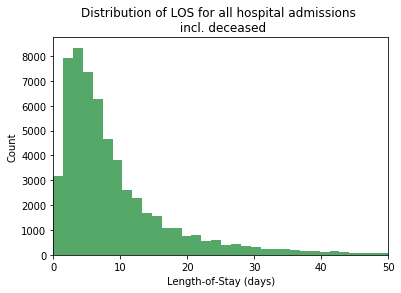

In [18]:
# Plot LOS Distribution
plt.hist(df['LOS'], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [19]:
# Pre-emptively drop some columns that I don't need anymore
df.drop(columns=['DISCHTIME', 'ROW_ID', 
                'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                'HAS_CHARTEVENTS_DATA'], inplace=True)

<a class="anchor" id="Deathtime"></a>
### 2.1.2 Deathtime

Patients who died at the hospital will later be **dropped** from the DataFrame as they would bias the LOS since they never were discharged 'alive' from the hospital. In other words, LOS would be shorter for this group. 

In [20]:
# Mark admissions where patients died in boolean column
df['DECEASED'] = df['DEATHTIME'].notnull().map({True:1, False:0})

In [21]:
print("{} of {} patients died in the hospital".format(df['DECEASED'].sum(), 
                                                     df['SUBJECT_ID'].nunique()))

5774 of 46445 patients died in the hospital


In [22]:
# Look at statistics less admissions resulting in death
df['LOS'].loc[df['DECEASED'] == 0].describe()

count    53104.000000
mean        10.138174
std         12.284461
min          0.014583
25%          3.866667
50%          6.565972
75%         11.711632
max        294.660417
Name: LOS, dtype: float64

In [23]:
# Hospital LOS metrics for later comparison
actual_mean_los = df['LOS'].loc[df['DECEASED'] == 0].mean() 
actual_median_los = df['LOS'].loc[df['DECEASED'] == 0].median() 

print(actual_mean_los)
print(actual_median_los)

10.138173704219758
6.565972222222222


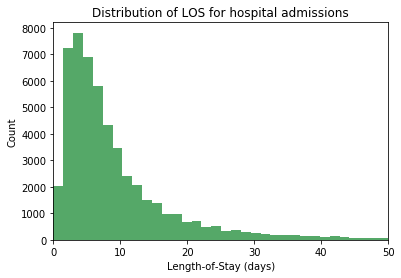

In [24]:
plt.hist(df['LOS'].loc[df['DECEASED'] == 0], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

<a class="anchor" id="Ethnicity"></a>
### 2.1.3 Ethnicity 

Given the large amount of categories in the 'ETHNICITY' series, my aim was to reduce the column to a few categories. Interestly, asians have the lowest median LOS. 

In [25]:
df['ETHNICITY'].value_counts()

WHITE                                                       40939
BLACK/AFRICAN AMERICAN                                       5434
UNKNOWN/NOT SPECIFIED                                        4502
HISPANIC OR LATINO                                           1693
ASIAN                                                        1508
OTHER                                                        1507
UNABLE TO OBTAIN                                              809
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85
WHITE - OT

In [26]:
# Compress the number of ethnicity categories
df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['ETHNICITY'].value_counts()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


WHITE                     41268
OTHER/UNKNOWN              7700
BLACK/AFRICAN AMERICAN     5779
HISPANIC/LATINO            2125
ASIAN                      2006
Name: ETHNICITY, dtype: int64

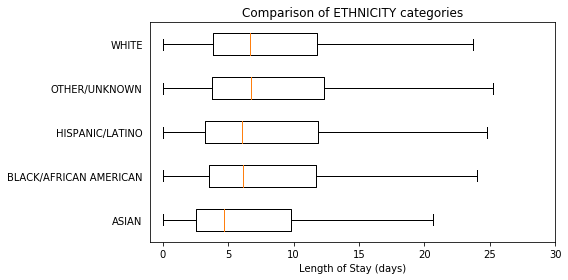

In [27]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by df categorical series name 
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();
    
# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    ''' 
    Boxplot of LOS by df categorical series name 
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df['LOS'].loc[df[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

boxplot_los_groupby('ETHNICITY', los_range=(-1, 30))

In [28]:
df['RELIGION'].value_counts()

CATHOLIC                  20580
NOT SPECIFIED             11738
UNOBTAINABLE               8242
PROTESTANT QUAKER          7121
JEWISH                     5307
OTHER                      2695
EPISCOPALIAN                771
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64

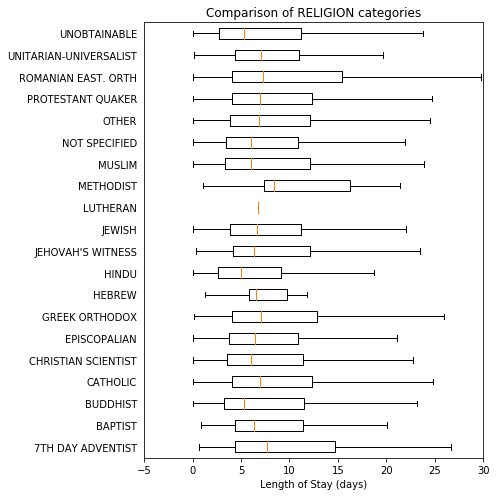

In [29]:
boxplot_los_groupby('RELIGION', los_range=(-5, 30), size=(7, 7))

In [30]:
# Reduce categories to terms of religious or not
# I tested with and without category reduction, with little change in R2 score
df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

print(df['RELIGION'].value_counts())
print(df['RELIGION'].value_counts()[0]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[1]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[2]/len(df['RELIGION']))

RELIGIOUS        38898
NOT SPECIFIED    11738
UNOBTAINABLE      8242
Name: RELIGION, dtype: int64
0.660654234179
0.199361391352
0.139984374469


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


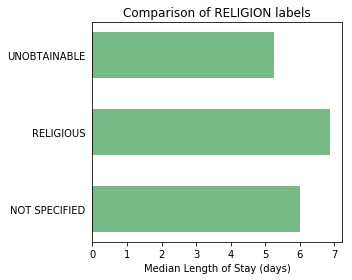

In [31]:
# Look at median LOS for groups
plot_los_groupby('RELIGION', size=(5,4))

<a class="anchor" id="Adm_type"></a>
### 2.1.5 Admission Type

Newborns have the lowest median LOS followed by elective admissions. This is expected since these are often somewhat planned for and with the risks being understood. 

In [32]:
df['ADMISSION_TYPE'].value_counts()

EMERGENCY    41989
NEWBORN       7854
ELECTIVE      7702
URGENT        1333
Name: ADMISSION_TYPE, dtype: int64

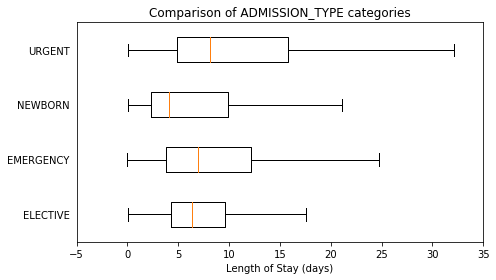

In [33]:
boxplot_los_groupby('ADMISSION_TYPE', los_range=(-5, 35), size=(7, 4))

<a class="anchor" id="Insurance"></a>
### 2.1.6 Insurance

If a patient is 'Self-Pay', typically means they can't or didn't pay. Self-pay patients have the lowest LOS.  

In [34]:
df['INSURANCE'].value_counts()

Medicare      28174
Private       22542
Medicaid       5778
Government     1781
Self Pay        603
Name: INSURANCE, dtype: int64

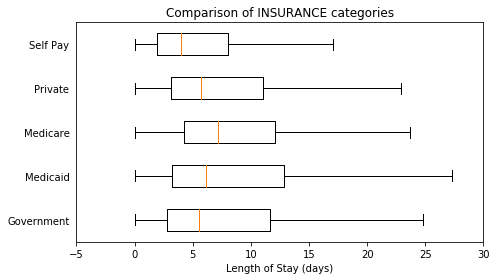

In [35]:
boxplot_los_groupby('INSURANCE', los_range=(-5, 30), size=(7, 4))

<a class="anchor" id="Marital"></a>
### 2.1.7 Marital status

In [36]:
df['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              24199
SINGLE               13238
NaN                  10097
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
UNKNOWN (DEFAULT)      343
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [37]:
# Fix NaNs and file under 'UNKNOWN'
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              24199
SINGLE               13238
UNKNOWN (DEFAULT)    10440
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

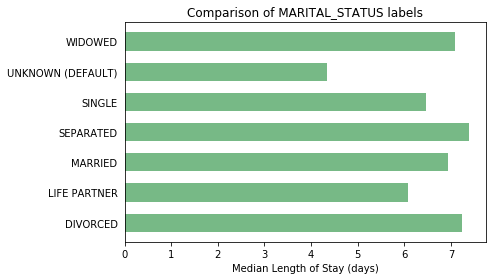

In [38]:
plot_los_groupby('MARITAL_STATUS')

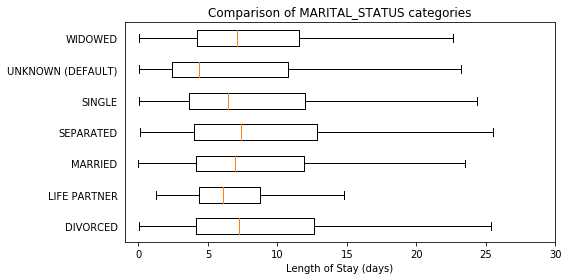

In [39]:
boxplot_los_groupby('MARITAL_STATUS')

<a class="anchor" id="DIAGNOSES_ICD.csv"></a>
## 2.2 DIAGNOSES_ICD.csv Exploration 

This section explore the ICUSTAYS.csv table of the MIMIC-III dataset. 

<a class="anchor" id="ICD_FE"></a>
### 2.2.1 ICD-9 Code Feature Engineering

From [Wiki](https://en.wikipedia.org/wiki/International_Statistical_Classification_of_Diseases_and_Related_Health_Problems#ICD-9): International Classification of Diseases, Clinical Modification (ICD-9-CM) is an adaption created by the U.S. National Center for Health Statistics (NCHS) and used in assigning diagnostic and procedure codes associated with inpatient, outpatient, and physician office utilization in the United States. 

In [40]:
# Imports
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#df_diagcode = pd.read_csv('DIAGNOSES_ICD.csv')
df_diagcode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
ROW_ID        651047 non-null int64
SUBJECT_ID    651047 non-null int64
HADM_ID       651047 non-null int64
SEQ_NUM       651000 non-null float64
ICD9_CODE     651000 non-null object
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [41]:
print('There are {} unique ICD9 codes in this dataset.'.format(df_diagcode['ICD9_CODE'].value_counts().count()))

There are 6984 unique ICD9 codes in this dataset.


Because it's not feasible to have 6984 unique values to use as features for predicting LOS, I need to reduce the diagnosis into more general categories. After researching the ICD9 approach, I discovery that they arranged into super categories as the following [(source)](https://en.wikipedia.org/wiki/List_of_ICD-9_codes):
* 001–139: infectious and parasitic diseases
* 140–239: neoplasms
* 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
* 280–289: diseases of the blood and blood-forming organs
* 290–319: mental disorders
* 320–389: diseases of the nervous system and sense organs
* 390–459: diseases of the circulatory system
* 460–519: diseases of the respiratory system
* 520–579: diseases of the digestive system
* 580–629: diseases of the genitourinary system
* 630–679: complications of pregnancy, childbirth, and the puerperium
* 680–709: diseases of the skin and subcutaneous tissue
* 710–739: diseases of the musculoskeletal system and connective tissue
* 740–759: congenital anomalies
* 760–779: certain conditions originating in the perinatal period
* 780–799: symptoms, signs, and ill-defined conditions
* 800–999: injury and poisoning
* E and V codes: external causes of injury and supplemental classification, *using 999 as placeholder even though it overlaps with complications of medical care*

Now the task is to re-code the in terms of these category groups. 

In [42]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['ICD9_CODE']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)

In [43]:
# https://stackoverflow.com/questions/46168450/replace-specific-range-of-values-in-data-frame-pandas
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

In [44]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]), 
            num, df_diagcode['recode'])
    
# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

In [45]:
# Verify
df_diagcode.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,recode,cat
0,1297,109,172335,1.0,40301,6,circulatory
1,1298,109,172335,2.0,486,7,respiratory
2,1299,109,172335,3.0,58281,9,genitourinary
3,1300,109,172335,4.0,5855,9,genitourinary
4,1301,109,172335,5.0,4254,6,circulatory


For each admission, there could be (and usually is) more than one diagnosis. Often, there are more than 1 diagnoses for 1 category. Therefore, I need to create a dummy matrix that highlights all the diagnoses for each admission. This should not be done on the SUBJECT_ID since each patient could have different diagnoses for each admission. 

In [46]:
# Create list of diagnoses for each admission
hadm_list = df_diagcode.groupby('HADM_ID')['cat'].apply(list).reset_index()
hadm_list.head()

,HADM_ID,cat
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood, infectious, digestive, circ..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."
3,100007,"[digestive, digestive, injury, respiratory, ci..."
4,100009,"[circulatory, injury, circulatory, endocrine, ..."


In [47]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0


In [48]:
# Join back with HADM_ID, will merge with main admissions DF later
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,HADM_ID
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1,100001
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,100003
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0,100006
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,100007
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0,100009


In [49]:
# Merge with main admissions df
df = df.merge(hadm_item, how='inner', on='HADM_ID')

In [50]:
# Verify Merge
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,4,1,0,0,0,1,0,0,0,0
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,1,0,0,0,0,1,0,0,0,0
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,3,0,0,0,1,1,0,1,0,0
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,0,0,0
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,0,0,0,0,0


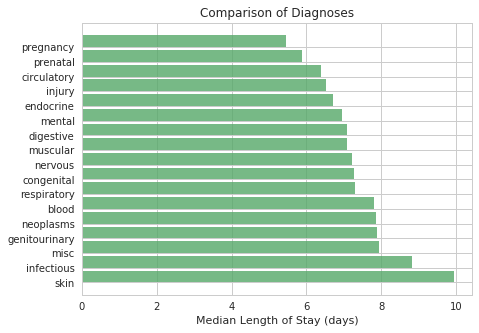

In [51]:
# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory', 
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(df[[variable, 'LOS']].groupby(variable).median().reset_index().values[1][1])

sns.set(style="whitegrid")
#sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnoses'.format(variable))
plt.show();

<a class="anchor" id="PATIENTS.csv"></a>
## 2.3 Patients.csv Exploration 

The PATIENTS table provides age and gender information. To protect identity, a patient’s age is given by the difference between their 'DOB' date of birth and the date of their first admission. Therefore, subsequent admissions for the same patient need to be ignored in the calculation. The only things that need to be done with this table are to extract the DOB and gender information and merge them with the admissions dataframe. 

In [52]:
df_pat.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [53]:
df_pat['GENDER'].value_counts()

M    26121
F    20399
Name: GENDER, dtype: int64

In [54]:
# Convert to datetime type
df_pat['DOB'] = pd.to_datetime(df_pat['DOB'])

In [55]:
df_pat = df_pat[['SUBJECT_ID', 'DOB', 'GENDER']]
df_pat.head()

,SUBJECT_ID,DOB,GENDER
0,249,2075-03-13,F
1,250,2164-12-27,F
2,251,2090-03-15,M
3,252,2078-03-06,M
4,253,2089-11-26,F


In [56]:
df = df.merge(df_pat, how='inner', on='SUBJECT_ID')

<a class="anchor" id="Age_FE"></a>
### 2.3.1 Age (Feature Engineering)

Now that the admissions dataFrame has DOB information, age can be calculated. 

In [57]:
# Find the first admission time for each patient
df_age_min = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
df_age_min.head()

,SUBJECT_ID,ADMIT_MIN
0,2,2138-07-17 19:04:00
1,3,2101-10-20 19:08:00
2,4,2191-03-16 00:28:00
3,5,2103-02-02 04:31:00
4,6,2175-05-30 07:15:00


In [58]:
df = df.merge(df_age_min, how='outer', on='SUBJECT_ID')

In [59]:
# Verify merge
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,DOB,GENDER,ADMIT_MIN
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,0,0,1,0,0,0,0,2131-05-07,F,2196-04-09 12:26:00
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,0,0,1,0,0,0,0,2082-07-17,M,2153-09-03 07:15:00
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,0,1,1,0,1,0,0,2082-07-17,M,2153-09-03 07:15:00
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,2100-05-31,M,2139-06-06 16:14:00
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,0,0,2101-11-21,M,2160-11-02 02:06:00


In [60]:
# Age is decode by finding the difference in admission date and date of birth
df['age'] = (df['ADMIT_MIN'] - df['DOB']).dt.days // 365
df['age'] = np.where(df['age'] < 0, 90, df['age'])
#df['age'] = np.where(df['age'] == -0, 0, df['age'])
df['age'].isnull().sum()

0

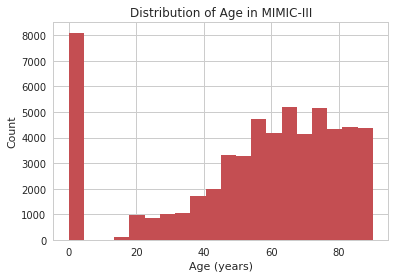

In [61]:
# Note that no ‘middle’ patients show up - this reflects the fact that MIMIC-III does not contain data from pediatric patients.
plt.hist(df['age'], bins=20, color='#c44e52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();

(1, 50)

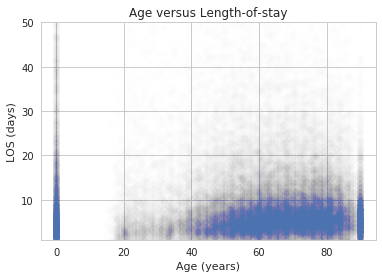

In [62]:
plt.scatter(df['age'], df['LOS'], alpha=0.005)
#plt.yscale('sqrt')
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(1, 50)

In [63]:
# https://en.wikipedia.org/wiki/List_of_ICD-9_codes
age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
for num, cat_range in enumerate(age_ranges):
    df['age'] = np.where(df['age'].between(cat_range[0],cat_range[1]), 
            num, df['age'])
    
age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
df['age'] = df['age'].replace(age_dict)
df.age.value_counts()

senior          33785
middle_adult    12732
newborn          8101
young_adult      4260
Name: age, dtype: int64

<a class="anchor" id="Gender"></a>
### 2.3.2 Gender

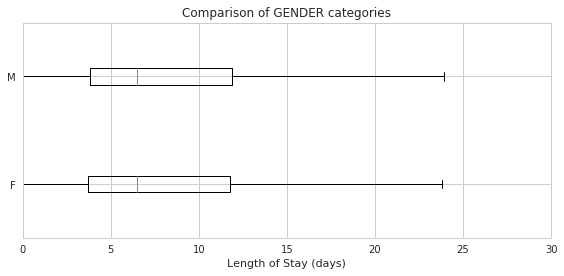

In [64]:
boxplot_los_groupby('GENDER', los_range=(0, 30))
df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)

<a class="anchor" id="ICUSTAYS.csv"></a>
## 2.4 ICUSTAYS.csv Exploration

In [65]:
# Intensive Care Unit (ICU) for each admission to hospital
df_icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
ROW_ID            61532 non-null int64
SUBJECT_ID        61532 non-null int64
HADM_ID           61532 non-null int64
ICUSTAY_ID        61532 non-null int64
DBSOURCE          61532 non-null object
FIRST_CAREUNIT    61532 non-null object
LAST_CAREUNIT     61532 non-null object
FIRST_WARDID      61532 non-null int64
LAST_WARDID       61532 non-null int64
INTIME            61532 non-null object
OUTTIME           61522 non-null object
LOS               61522 non-null float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


In [66]:
df_icu['HADM_ID'].nunique()

57786

In [67]:
df_icu.groupby('FIRST_CAREUNIT').median()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_WARDID,LAST_WARDID,LOS
FIRST_CAREUNIT,,,,,,,
CCU,29091.5,22964.5,150074.5,249373.5,7.0,7.0,2.19775
CSRU,31002.5,24488.0,150225.0,250492.0,14.0,14.0,2.15290
MICU,33612.5,26489.5,150368.0,250524.0,50.0,50.0,2.09550
NICU,19581.5,15456.5,149206.5,249308.0,56.0,56.0,0.80250
SICU,38089.0,30084.0,149744.0,248649.0,33.0,33.0,2.25220
TSICU,36382.0,28716.0,148915.0,250685.0,14.0,14.0,2.11150


<a class="anchor" id="ICU_FE"></a>
### 2.4.1 ICU (Feature Engineering)

In [68]:
# Based on above statistics, reduce to just ICU and NICU groups
df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

In [69]:
df_icu['cat'] = df_icu['FIRST_CAREUNIT']
icu_list = df_icu.groupby('HADM_ID')['cat'].apply(list).reset_index()
icu_list.head()

,HADM_ID,cat
0,100001,[ICU]
1,100003,[ICU]
2,100006,[ICU]
3,100007,[ICU]
4,100009,[ICU]


In [70]:
df_icu['FIRST_CAREUNIT'].value_counts()

ICU     53432
NICU     8100
Name: FIRST_CAREUNIT, dtype: int64

In [71]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
icu_item.head()

,ICU,NICU,HADM_ID
0,1,0,100001
1,1,0,100003
2,1,0,100006
3,1,0,100007
4,1,0,100009


In [72]:
print("Number of admissions to ICU {}.".format(icu_item.ICU.sum()))
print("Number of admissions to NICU {}.".format(icu_item.NICU.sum()))

Number of admissions to ICU 49794.
Number of admissions to NICU 7992.


In [73]:
# Merge ICU data with main dataFrame
df = df.merge(icu_item, how='outer', on='HADM_ID')

In [74]:
# Replace NaNs with 0
df['ICU'].fillna(value=0, inplace=True)
df['NICU'].fillna(value=0, inplace=True)

In [75]:
# Verify NaN fix
print(df.ICU.value_counts(dropna=False))
print(df.NICU.value_counts(dropna=False))

1.0    49794
0.0     9168
Name: ICU, dtype: int64
0.0    50970
1.0     7992
Name: NICU, dtype: int64


<a class="anchor" id="Data-Preprocessing"></a>
# 3. Data Preprocessing

Even after completing the feature engineering for age and ICD-9, there were some loose ends that needed tidying up before the data could be used for the prediction model. First, I ensured that no admissions resulting in death were part the cleaned dataset. I dropped all unused columns and verified that no NaNs existed in the data. For the admission type, insurance type, religion, ethnicity, age, and marital status columns, I performed the Pandas get_dummies command to convert these categorical variables into dummy/indicator variables. The final DataFrame size resulted in 48 feature columns and 1 target column with an entry count of 53,104.

In [76]:
# Look at what is no longer needed in the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58962 entries, 0 to 58961
Data columns (total 38 columns):
SUBJECT_ID            58878 non-null float64
HADM_ID               58962 non-null int64
ADMITTIME             58878 non-null datetime64[ns]
DEATHTIME             5774 non-null object
ADMISSION_TYPE        58878 non-null object
ADMISSION_LOCATION    58878 non-null object
DISCHARGE_LOCATION    58878 non-null object
INSURANCE             58878 non-null object
LANGUAGE              33606 non-null object
RELIGION              58878 non-null object
MARITAL_STATUS        58878 non-null object
ETHNICITY             58878 non-null object
DIAGNOSIS             58853 non-null object
LOS                   58878 non-null float64
DECEASED              58878 non-null float64
blood                 58878 non-null float64
circulatory           58878 non-null float64
congenital            58878 non-null float64
digestive             58878 non-null float64
endocrine             58878 non-null float

In [77]:
# Remove deceased persons as they will skew LOS result
df = df[df['DECEASED'] == 0]

# Remove LOS with negative number, likely entry form error
df = df[df['LOS'] > 0]

In [78]:
# Drop unused or no longer needed columns
df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE', 'ADMIT_MIN', 'DOB',
                'DIAGNOSIS', 'DECEASED',  'DEATHTIME'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53104 entries, 0 to 58877
Data columns (total 27 columns):
ADMISSION_TYPE    53104 non-null object
INSURANCE         53104 non-null object
RELIGION          53104 non-null object
MARITAL_STATUS    53104 non-null object
ETHNICITY         53104 non-null object
LOS               53104 non-null float64
blood             53104 non-null float64
circulatory       53104 non-null float64
congenital        53104 non-null float64
digestive         53104 non-null float64
endocrine         53104 non-null float64
genitourinary     53104 non-null float64
infectious        53104 non-null float64
injury            53104 non-null float64
mental            53104 non-null float64
misc              53104 non-null float64
muscular          53104 non-null float64
neoplasms         53104 non-null float64
nervous           53104 non-null float64
pregnancy         53104 non-null float64
prenatal          53104 non-null float64
respiratory       53104 non-null fl

In [79]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR', 'RELIGION']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'age', 'MARITAL_STATUS', 'RELIGION']
df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53104 entries, 0 to 58877
Data columns (total 52 columns):
LOS                           53104 non-null float64
blood                         53104 non-null float64
circulatory                   53104 non-null float64
congenital                    53104 non-null float64
digestive                     53104 non-null float64
endocrine                     53104 non-null float64
genitourinary                 53104 non-null float64
infectious                    53104 non-null float64
injury                        53104 non-null float64
mental                        53104 non-null float64
misc                          53104 non-null float64
muscular                      53104 non-null float64
neoplasms                     53104 non-null float64
nervous                       53104 non-null float64
pregnancy                     53104 non-null float64
prenatal                      53104 non-null float64
respiratory                   53104 non-nul

In [80]:
# Verify
df.head()

,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED,RELIGION_NOT SPECIFIED,RELIGION_RELIGIOUS,RELIGION_UNOBTAINABLE
0,1.144444,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,...,0,0,1,0,0,0,0,0,0,1
1,5.496528,0.0,4.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,6.768056,0.0,2.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,...,0,0,1,0,0,0,0,0,1,0
3,2.856944,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
4,3.534028,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1


Now, save the data to the project.  We will use Watson Machine Learning and the SPSS Flow Editor to create some experiments to build and publish some regression models to see if we can build predictors that are better than the mean and median values.

Click the three . icon above and insert a project token to the notebook.
Run that project token cell, then run the cell below to create your csv file that will be exported to the project.

In [87]:
project.save_data("Training.csv", df.to_csv())

{'asset_id': 'dd54b127-bd72-4b92-81ef-645c3d24fc5f',
 'bucket_name': 'ehr-donotdelete-pr-6jccsvqauc2mul',
 'file_name': 'Training.csv',
 'message': 'File Training.csv has been written successfully to the associated OS'}

### END